# Рисование Фурьями

Объяснение [тут](https://habr.com/ru/post/530652/)

In [1]:
cd(s"C:\Users\User\Desktop\Mycop\plots2")

In [60]:
using Images, FFTW#, TestImages, FileIO

- [Обнаружение контуров](https://habr.com/ru/post/467611/)
- [Эвристики для Комивояджера](https://opensourc.es/blog/mip-tsp/)

- [Пакет для контуров](https://juliageometry.github.io/Contour.jl/stable/tutorial.html)
- [Images.jl](https://juliaimages.org/latest/democards/examples/contours/contour_detection/)


In [61]:
# rotate direction clocwise
function clockwise(dir)
    return (dir)%8 + 1
end

# rotate direction counterclocwise
function counterclockwise(dir)
    return (dir+6)%8 + 1
end

# move from current pixel to next in given direction
function move(pixel, image, dir, dir_delta)
    newp = pixel + dir_delta[dir]
    height, width = size(image)
    if (0 < newp[1] <= height) &&  (0 < newp[2] <= width)
        if image[newp]!=0
            return newp
        end
    end
    return CartesianIndex(0, 0)
end

# finds direction between two given pixels
function from_to(from, to, dir_delta)
    delta = to-from
    return findall(x->x == delta, dir_delta)[1]
end;

In [62]:
function detect_move(image, p0, p2, nbd, border, done, dir_delta)
    dir = from_to(p0, p2, dir_delta)
    moved = clockwise(dir)
    p1 = CartesianIndex(0, 0)
    while moved != dir ## 3.1
        newp = move(p0, image, moved, dir_delta)
        if newp[1]!=0
            p1 = newp
            break
        end
        moved = clockwise(moved)
    end

    if p1 == CartesianIndex(0, 0)
        return
    end

    p2 = p1 ## 3.2
    p3 = p0 ## 3.2
    done .= false
    while true
        dir = from_to(p3, p2, dir_delta)
        moved = counterclockwise(dir)
        p4 = CartesianIndex(0, 0)
        done .= false
        while true ## 3.3
            p4 = move(p3, image, moved, dir_delta)
            if p4[1] != 0
                break
            end
            done[moved] = true
            moved = counterclockwise(moved)
        end
        push!(border, p3) ## 3.4
        if p3[1] == size(image, 1) || done[3]
            image[p3] = -nbd
        elseif image[p3] == 1
            image[p3] = nbd
        end

        if (p4 == p0 && p3 == p1) ## 3.5
            break
        end
        p2 = p3
        p3 = p4
    end
end

detect_move (generic function with 1 method)

In [63]:
function find_contours(image)
    nbd = 1
    lnbd = 1
    image = Float64.(image)
    contour_list =  Vector{typeof(CartesianIndex[])}()
    done = [false, false, false, false, false, false, false, false]

    # Clockwise Moore neighborhood.
    dir_delta = [CartesianIndex(-1, 0) , CartesianIndex(-1, 1), CartesianIndex(0, 1), 
        CartesianIndex(1, 1), CartesianIndex(1, 0), CartesianIndex(1, -1), 
        CartesianIndex(0, -1), CartesianIndex(-1,-1)]

    height, width = size(image)

    for i=1:height
        lnbd = 1
        for j=1:width
            fji = image[i, j]
            is_outer = (image[i, j] == 1 && (j == 1 || image[i, j-1] == 0)) ## 1 (a)
            is_hole = (image[i, j] >= 1 && (j == width || image[i, j+1] == 0))

            if is_outer || is_hole
                # 2
                border = CartesianIndex[]

                from = CartesianIndex(i, j)

                if is_outer
                    nbd += 1
                    from -= CartesianIndex(0, 1)

                else
                    nbd += 1
                    if fji > 1
                        lnbd = fji
                    end
                    from += CartesianIndex(0, 1)
                end

                p0 = CartesianIndex(i,j)
                detect_move(image, p0, from, nbd, border, done, dir_delta) ## 3
                if isempty(border) ##TODO
                    push!(border, p0)
                    image[p0] = -nbd
                end
                push!(contour_list, border)
            end
            if fji != 0 && fji != 1
                lnbd = abs(fji)
            end

        end
    end
    return contour_list
end

find_contours (generic function with 1 method)

In [64]:
# a contour is a vector of 2 int arrays
function draw_contour(image, color, contour)
    for ind in contour
        image[ind] = color
    end
end
function draw_contours(image, color, contours)
    for cnt in contours
        draw_contour(image, color, cnt)
    end
end

draw_contours (generic function with 1 method)

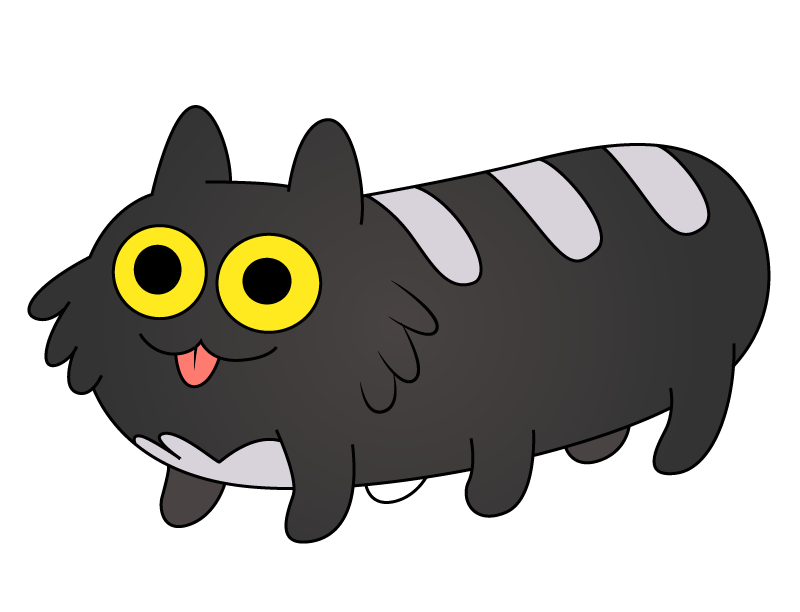

In [76]:
img1 = load("cat3.png")

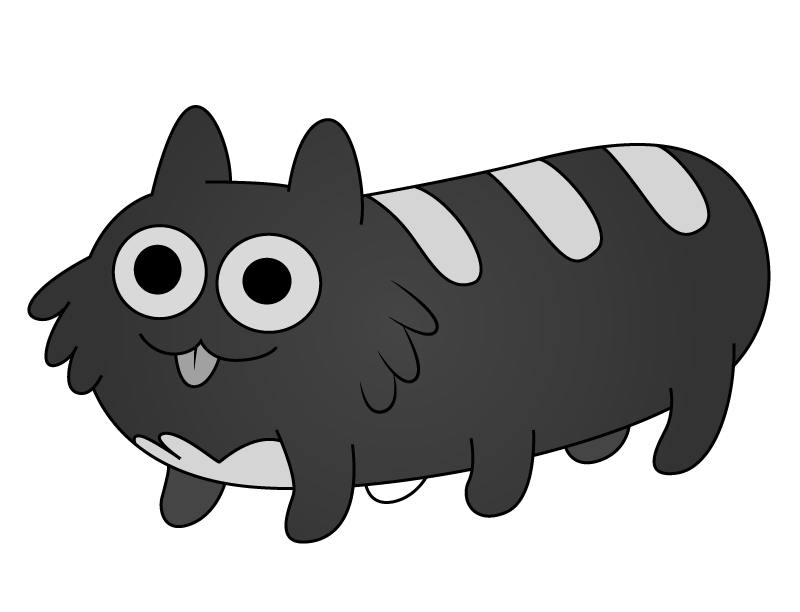

In [77]:
imgg1 = Gray.(img1)

In [84]:
imgg1 = Gray.(img1)

# threshold
imgg1 = imgg1 .> 0.15;

In [85]:
# calling find_contours
cnts1 = find_contours(imgg1)

img3 = copy(img1)

# finally, draw the detected contours
draw_contours(img3, RGB(1,0,0), cnts1)

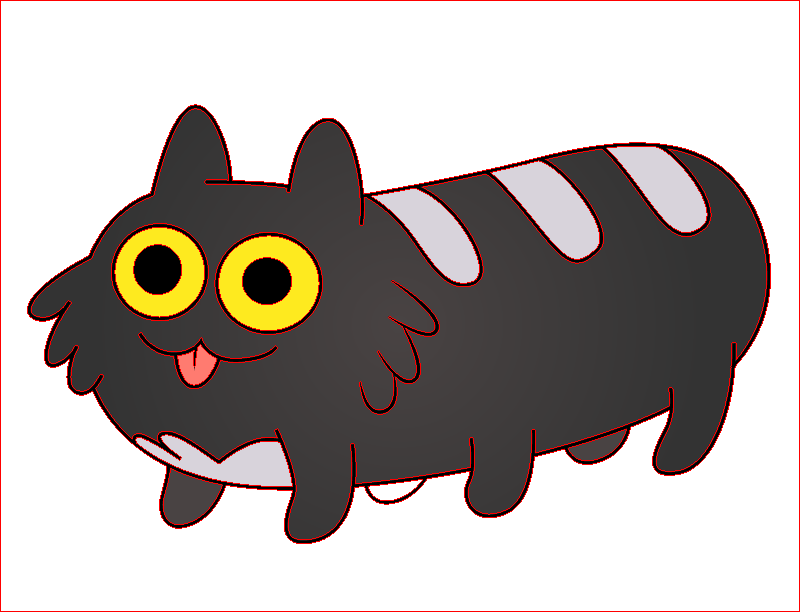

In [86]:
img3

In [87]:
using Plots

In [88]:
X = Int64[]
Y = Int64[]
for c_i in cnts1[2:end], c in c_i
    push!(X, c[2])
    push!(Y, c[1])
end

In [93]:
length(X), length(X[1:10:end])

(9369, 937)

разреживаем (меньше точек - меньше считать):

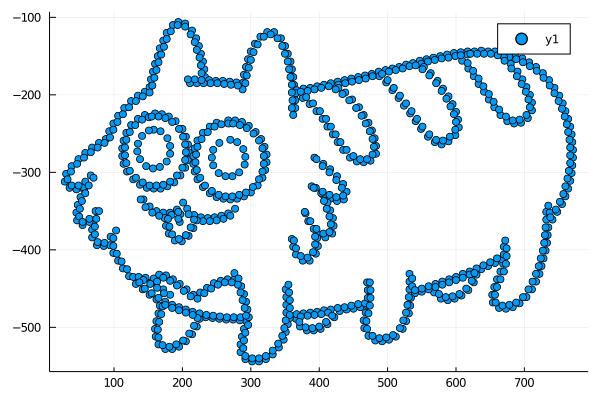

In [92]:
scatter(X[1:10:end], -Y[1:10:end])
#xaxis!((350, 400))
#yaxis!((-500, -450))

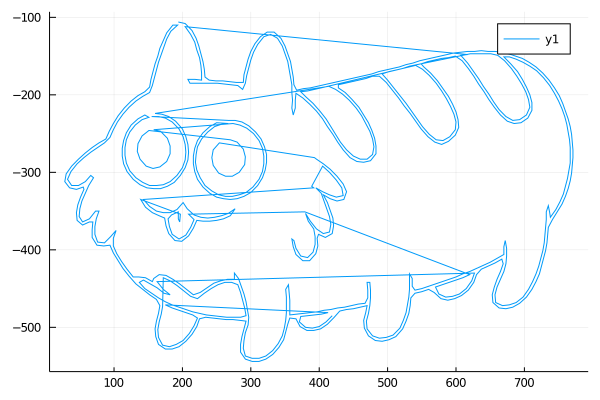

In [94]:
plot(X[1:10:end],-Y[1:10:end])

Статья про [Luxor](https://habr.com/ru/post/459842/)

In [3]:
using Luxor

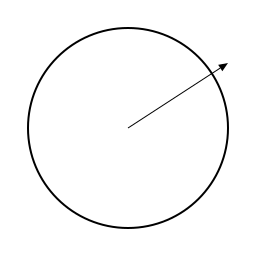

In [4]:
@png begin
    circle(Point(0, 0), 100, :stroke)
    arrow(Point(0, 0), Point(100, -65))
end 256 256 "cirk.png"

In [38]:
function dft_epicycles(Z, N)
    # Discrete Fourier Transform
    X = fft(Z)/N;       # DFT of the complex series
    freq = 0:N-1;     # Frequency of the circles
    radius = abs.(X)    # Radii of the circles
    phase = angle.(X)   # Initial phase of the circles
    # Sort by radius
    idx = sortperm(radius, rev = true)
    radius = sort(radius, rev = true)
    X = X[idx]
    freq = freq[idx]
    phase = phase[idx]

    X, freq, radius, phase
end

dft_epicycles (generic function with 1 method)

In [103]:
# Draws the epicycles and the result line at a given time
function draw_epicycles(freq, radius, phase, tim, wave, k)
    # Compute coordinates
    p = O
    N = length(freq)
    centers = Point[]
    push!(centers, p)
    
    for i = 1:N
        # new circle
        ϕ = freq[i]*tim + phase[i]
        r = radius[i]
        # Get the new coordinates of the joint point
        p = p + Point( r*cos(ϕ), r*sin(ϕ) )
        # Circle centers
        push!(centers, p)
    end    
    # plot circles
    if k % 5 == 0
        @png begin
            for i in 1:length(radius)-1
                circle(centers[i], radius[i], :stroke)
                arrow(centers[i], centers[i+1])
            end

            if length(wave)>1
                sethue("red")
                poly(wave, :stroke)
            end
        end 1600 1100 "pix/step_$k.png"
    end
    
    return p
end

draw_epicycles (generic function with 1 method)

In [98]:
function fourier_epicycles(curve_x, curve_y, no_circles)

    # Compute the DFT of the complex number
    Z = curve_x + im*curve_y
    N = length(Z)
    X, freq, radius, phase = dft_epicycles(Z, N)
    time_step = 2pi/N
    
    # Draw the result
    tim = 0
    wave = Point[]
    for generation = 0:N+2
        p = draw_epicycles(freq, radius, phase, tim, wave, generation)
        # Add the next computed point to the wave curve
        push!(wave, p)
        # Increment time and generation
        tim += time_step;
    end
end

fourier_epicycles (generic function with 1 method)

In [55]:
xx = [150, -140, -160, 130, 150]
yy = [150, 160, -150, -140, 150];

In [56]:
fourier_epicycles(xx, yy, 5)

In [100]:
length(X[1:10:end])

937

In [104]:
@time fourier_epicycles(X[1:10:end], Y[1:10:end], length(X[1:10:end]))

 49.647091 seconds (6.21 M allocations: 274.329 MiB, 0.12% gc time)
